21:01:27 - cmdstanpy - INFO - Chain [1] start processing
21:01:29 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/22 [00:00<?, ?it/s]

21:01:30 - cmdstanpy - INFO - Chain [1] start processing
21:01:30 - cmdstanpy - INFO - Chain [1] done processing
21:01:30 - cmdstanpy - INFO - Chain [1] start processing
21:01:31 - cmdstanpy - INFO - Chain [1] done processing
21:01:31 - cmdstanpy - INFO - Chain [1] start processing
21:01:31 - cmdstanpy - INFO - Chain [1] done processing
21:01:32 - cmdstanpy - INFO - Chain [1] start processing
21:01:33 - cmdstanpy - INFO - Chain [1] done processing
21:01:34 - cmdstanpy - INFO - Chain [1] start processing
21:01:34 - cmdstanpy - INFO - Chain [1] done processing
21:01:34 - cmdstanpy - INFO - Chain [1] start processing
21:01:35 - cmdstanpy - INFO - Chain [1] done processing
21:01:36 - cmdstanpy - INFO - Chain [1] start processing
21:01:37 - cmdstanpy - INFO - Chain [1] done processing
21:01:37 - cmdstanpy - INFO - Chain [1] start processing
21:01:38 - cmdstanpy - INFO - Chain [1] done processing
21:01:38 - cmdstanpy - INFO - Chain [1] start processing
21:01:39 - cmdstanpy - INFO - Chain [1]


Cross-Validation Metrics:
  horizon      rmse       mse  coverage
0 36 days  0.011971  0.000143  0.808770
1 37 days  0.012430  0.000155  0.803978
2 38 days  0.012558  0.000158  0.801929
3 39 days  0.012584  0.000158  0.805606
4 40 days  0.012480  0.000156  0.810805

Test Set Performance Metrics:
{'MAE': np.float64(0.008217703246120011), 'MSE': np.float64(0.0001563643478915527), 'RMSE': np.float64(0.012504573079139995)}


21:02:03 - cmdstanpy - INFO - Chain [1] start processing
21:02:03 - cmdstanpy - INFO - Chain [1] done processing


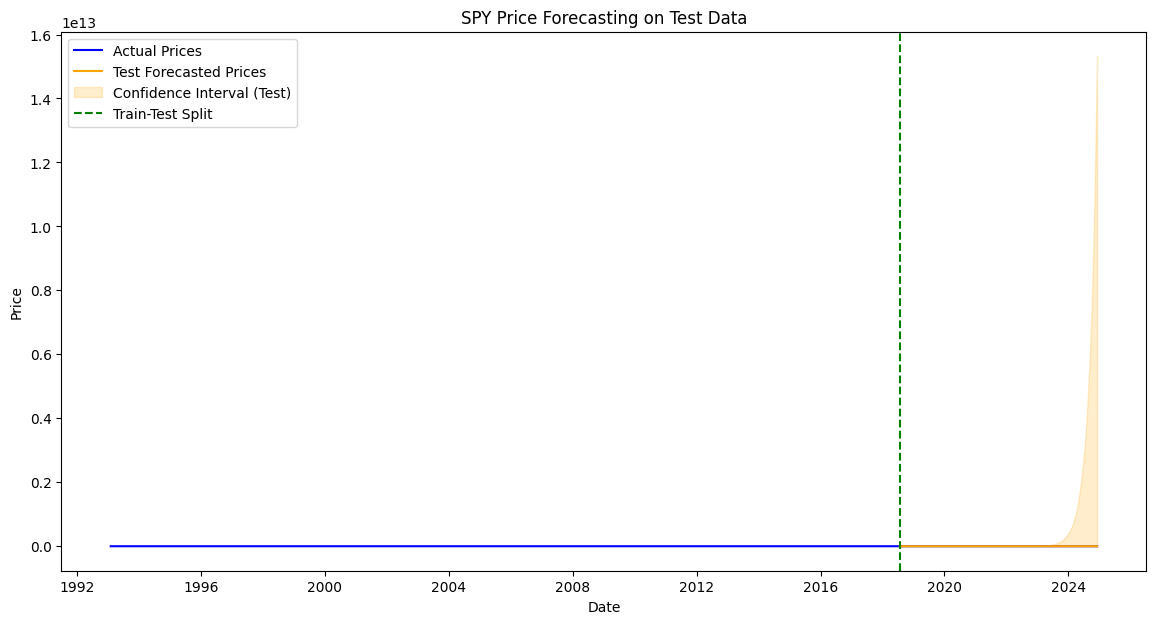

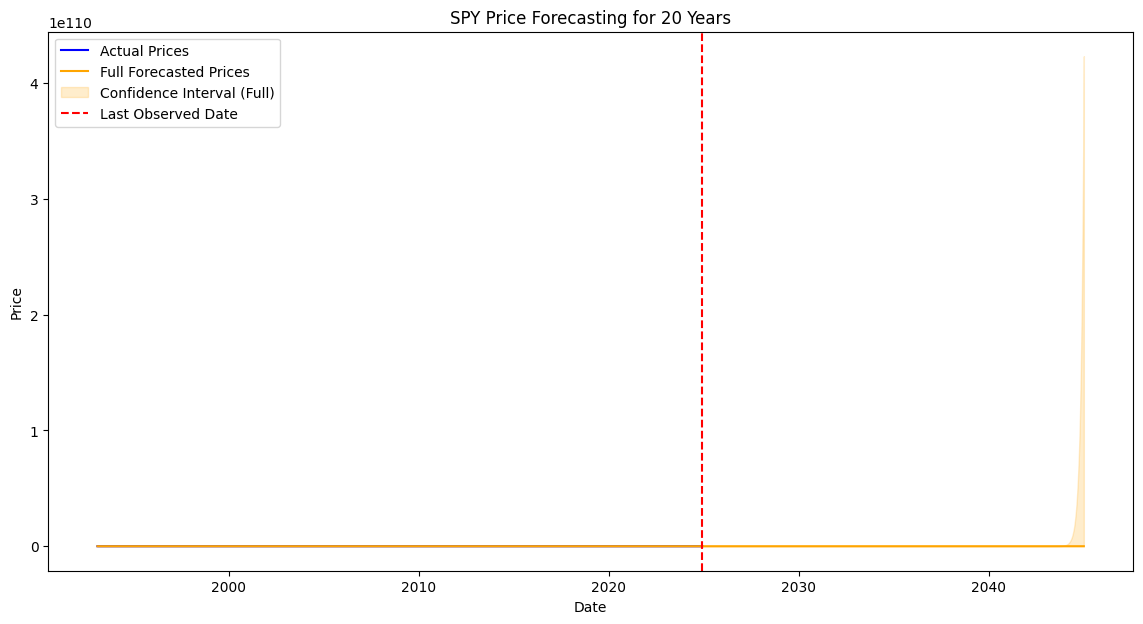


Sample of Full Forecasted Prices:
              ds  predicted_price   price_lower    price_upper
15346 2044-12-27     4.660895e+10  5.666121e-90  3.948945e+110
15347 2044-12-28     4.670432e+10  5.591506e-90  4.020396e+110
15348 2044-12-29     4.678721e+10  5.514173e-90  4.087351e+110
15349 2044-12-30     4.687651e+10  5.441984e-90  4.154378e+110
15350 2044-12-31     4.714471e+10  5.398273e-90  4.233253e+110


In [4]:
import pandas as pd
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Load and Preprocess Data
spy_full = pd.read_csv(r'..\Data\spy_full.csv')
spy_full.rename(columns={'date': 'ds', 'log_return': 'y'}, inplace=True)  # Rename for Prophet
spy_full['ds'] = pd.to_datetime(spy_full['ds'])  # Convert to datetime
spy_full.dropna(subset=['y'], inplace=True)  # Remove missing values

# Train-test split (80% train, 20% test)
train_size = int(0.8 * len(spy_full))
train_data = spy_full.iloc[:train_size]
test_data = spy_full.iloc[train_size:]

# Step 2: Train Prophet Model for Test Data Inference
model = Prophet()
model.fit(train_data)

# Perform cross-validation
cv_results = cross_validation(model, initial='1095 days', period='365 days', horizon='365 days')
cv_metrics = performance_metrics(cv_results)

print("\nCross-Validation Metrics:")
print(cv_metrics[['horizon', 'rmse', 'mse', 'coverage']].head())

# Predict log returns for the test dataset
future_test = test_data[['ds']].copy()
forecast_test = model.predict(future_test)

# Transform predicted log returns back to prices
last_train_price = spy_full.loc[train_data.index[-1], 'adj_close']  # Last observed price in training
forecast_test['predicted_price'] = last_train_price * np.exp(forecast_test['yhat'].cumsum())
forecast_test['price_lower'] = last_train_price * np.exp(forecast_test['yhat_lower'].cumsum())
forecast_test['price_upper'] = last_train_price * np.exp(forecast_test['yhat_upper'].cumsum())

# Evaluate Test Data Predictions
def evaluate_performance(actual, predicted):
    actual_values = actual['y'].values
    predicted_values = predicted['yhat'].values
    mae = abs(actual_values - predicted_values).mean()
    mse = ((actual_values - predicted_values) ** 2).mean()
    rmse = mse ** 0.5
    return {"MAE": mae, "MSE": mse, "RMSE": rmse}

test_performance = evaluate_performance(test_data, forecast_test)
print("\nTest Set Performance Metrics:")
print(test_performance)

# Step 3: Train Prophet Model on Full Dataset for Long-Term Forecasting
model_full = Prophet()
model_full.fit(spy_full)

# Create a future dataframe for 20 years
from datetime import datetime
last_date = spy_full['ds'].max()
target_end_date = datetime(2044, 12, 31)
days_to_forecast = (target_end_date - last_date).days

future_full = model_full.make_future_dataframe(periods=days_to_forecast, freq='D')
forecast_full = model_full.predict(future_full)

# Transform predicted log returns back to prices
last_full_price = spy_full['adj_close'].iloc[-1]  # Last observed price in the full dataset
forecast_full['predicted_price'] = last_full_price * np.exp(forecast_full['yhat'].cumsum())
forecast_full['price_lower'] = last_full_price * np.exp(forecast_full['yhat_lower'].cumsum())
forecast_full['price_upper'] = last_full_price * np.exp(forecast_full['yhat_upper'].cumsum())

# Step 4: Visualizations
# Test Data Prediction Visualization
plt.figure(figsize=(14, 7))
plt.plot(spy_full['ds'], spy_full['adj_close'], label="Actual Prices", color="blue")
plt.plot(forecast_test['ds'], forecast_test['predicted_price'], label="Test Forecasted Prices", color="orange")
plt.fill_between(
    forecast_test['ds'], forecast_test['price_lower'], forecast_test['price_upper'],
    color="orange", alpha=0.2, label="Confidence Interval (Test)"
)
plt.axvline(x=train_data['ds'].iloc[-1], color='green', linestyle='--', label='Train-Test Split')
plt.title("SPY Price Forecasting on Test Data")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Full Forecast Visualization
plt.figure(figsize=(14, 7))
plt.plot(spy_full['ds'], spy_full['adj_close'], label="Actual Prices", color="blue")
plt.plot(forecast_full['ds'], forecast_full['predicted_price'], label="Full Forecasted Prices", color="orange")
plt.fill_between(
    forecast_full['ds'], forecast_full['price_lower'], forecast_full['price_upper'],
    color="orange", alpha=0.2, label="Confidence Interval (Full)"
)
plt.axvline(x=spy_full['ds'].iloc[-1], color='red', linestyle='--', label='Last Observed Date')
plt.title("SPY Price Forecasting for 20 Years")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

# Save forecasted prices
forecast_test[['ds', 'predicted_price', 'price_lower', 'price_upper']].to_csv('test_forecasted_prices_log_returns.csv', index=False)
forecast_full[['ds', 'predicted_price', 'price_lower', 'price_upper']].to_csv('full_forecasted_prices_log_returns.csv', index=False)

print("\nSample of Full Forecasted Prices:")
print(forecast_full[['ds', 'predicted_price', 'price_lower', 'price_upper']].tail())
